# Style Transfer 
Implementation of original style tranfer paper (https://arxiv.org/abs/1508.06576) with improved losses from https://arxiv.org/abs/1603.08155


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf
import numpy as np
from PIL import Image
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import imagenet_utils
from keras import backend as K
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, HTML
from IPython.display import display, Image
from functools import partial
import utils; reload(utils)
from utils import *
from IPython.core.debugger import Tracer
from display_graph import display_graph
import pprint
import time

%matplotlib inline

Using TensorFlow backend.


## Image loading and generating routines

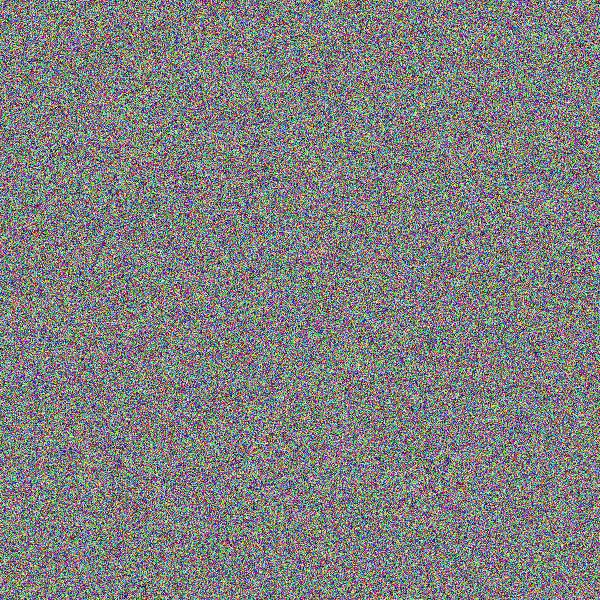

In [20]:
def random_image(size,):
    '''Generate a random noise image and return it as np array. 
        Args:
            size: The desired dimensions of the output image.
            random_noise: Whether to generate a random noise 
             image or to load a picture.
            filename: The fullpath to the image to load.
    '''
    width, height = size
    # Generate a random noise image
    # 3 is the number of channels (RGB) in the image.
    img = np.random.random(size=(width, height, 3))
    img_array = img * 256 
    return img_array

def load_image(size, filename=None):
    '''Load image from disc and return it as np array. 
        Args:
            size: The desired dimensions of the output image.
            filename: The fullpath to the image to load.
    '''
    width, height = size

    if not filename:
        raise ValueError('If not generating random noise image, image filename is required.')
    # Load a picture
    img = PIL.Image.open(filename)
    img = img.resize((width, height))
    img_array = np.asarray(img.copy())
    return img_array

# Output image size
image_size = (600, 600)

# Get and displaying image
image = random_image(size=image_size)
show(image)

## Load model

In [9]:
graph = tf.Graph()
config = tf.ConfigProto()
# Uncomment this if you want to use two iPython scripts side by side, 
# and you dont want tensorflow to take up all the GPU memory on initialization
# config.gpu_options.allow_growth=True

# Interactive session is better suited for notebooks
sess = tf.InteractiveSession(graph=graph, config=config)
K.set_session(sess)

# Keras flag - we are not training, just testing now
K.set_learning_phase(0)


def setup_model(initial_value, model_name='Inception5h'):
    '''Load the model. Use a TF tensor as input just for fun.
    Args: 
        initial_value: The initial value of the input tensor. Mainly used for size.
        model_name: Whether to normalize the input image.
    Returns:
        Tuple of (model, # The loaded keras model
            input_tensor, # The tensor that feeds the model
            content_layers, # The content layers of this model as tensors
            style_layers, # The style layers of this model as tensors
            preprocess_func, # Preprocesses an image for the model
            deprocess_func # Returns preprocessed image back to normal.
    '''
    # Prepare tensor for input image
    image_tensor = tf.Variable(initial_value)
    
    if model_name == 'VGG16' or model == 'VGG19':
        # These two models share a lot, so define them together
        if model_name == 'VGG16':
            # VGG 16 model
            model = VGG16(include_top=False, weights='imagenet',
                         input_tensor=image_tensor)
        elif model_name == 'VGG19':
            model = VGG19(include_top=False, weights='imagenet',
                         input_tensor=image_tensor)
            
        # Preprocesses an image for the model
        def preprocess_func(x):
            x = x.copy().astype(float)
            rank = len(x.shape)
            if (rank == 3):
                # Add extra batch dimension
                x = np.expand_dims(x, axis=0)
            x[:, :, :, 2] -= 103.939
            x[:, :, :, 1] -= 116.779
            x[:, :, :, 0] -= 123.68
            return x

        # Returns preprocessed image back to normal.
        def deprocess_func(x):
            x = np.asarray(x).copy()
            rank = len(x.shape)
            if (rank == 4):
                # Remove extra batch dimension
                x = np.squeeze(x, axis=0)

            # Remove zero-center by mean pixel
            x[:, :, 2] += 103.939
            x[:, :, 1] += 116.779
            x[:, :, 0] += 123.68

            x = np.clip(x, 0, 255).astype('uint8')
            return x

        # Define the style layers
        style_layers = [model.get_layer('block1_conv1').output,
                        model.get_layer('block2_conv1').output,
                        model.get_layer('block3_conv1').output,
                        model.get_layer('block4_conv1').output,
                        model.get_layer('block5_conv1').output]
        
        # Define the content layers
        content_layers = model.get_layer('block4_conv2').output

    # TODO: Add other models
    
    return model, image_tensor, content_layers, style_layers, preprocess_func, deprocess_func

with graph.as_default():
    with graph.name_scope("model") as scope:
        # Use the image size (with a batch dimension) to feed the model input. 
        # We do so that the input has size and the convolutional layers
        # will be sized as well. 
        initial = np.expand_dims(image, axis=0).astype('float32')
        
        # Setup the model
        (model, input_tensor, content_layers, style_layers, 
         preprocess, deprocess) = setup_model(
            initial_value=initial,
            model_name='VGG16')

In [10]:
# Checkout what we got
(model, input_tensor, content_layers, style_layers, 
         preprocess, deprocess) 


(<keras.engine.training.Model at 0x1170a8510>,
 <tf.Tensor 'model/Relu_8:0' shape=(1, 75, 75, 512) dtype=float32>,
 [<tf.Tensor 'model/Relu:0' shape=(1, 600, 600, 64) dtype=float32>,
  <tf.Tensor 'model/Relu_2:0' shape=(1, 300, 300, 128) dtype=float32>,
  <tf.Tensor 'model/Relu_4:0' shape=(1, 150, 150, 256) dtype=float32>,
  <tf.Tensor 'model/Relu_7:0' shape=(1, 75, 75, 512) dtype=float32>,
  <tf.Tensor 'model/Relu_10:0' shape=(1, 37, 37, 512) dtype=float32>],
 <function __main__.preprocess_func>,
 <function __main__.deprocess_func>)

In [11]:
# Summary of the model layers
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (1, 600, 600, 3)      0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (1, 600, 600, 64)     1792        input_4[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (1, 600, 600, 64)     36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (1, 300, 300, 64)     0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [12]:
# Uncomment this to print all operations in the graph so far
# print('\n'.join([op.name for op in graph.get_operations()]))

# Style transfer

### Style transfer simplest algo
1. Load the style and content images.
2. Compute the style layers activations of the style input image, 
and the content layer activations of the content input image.
3. Define Style difference between current image and style input image.
4. Define Content loss between current image and content image.
5. Define Total variance loss (prevents noise in result).
6. Define the gradient to change a result image to minimize 
the total loss = style loss + content loss + total variance loss
7. Modify the result image by the gradient
for a number of iterations.

## Step 1 
Get the style and the content image.

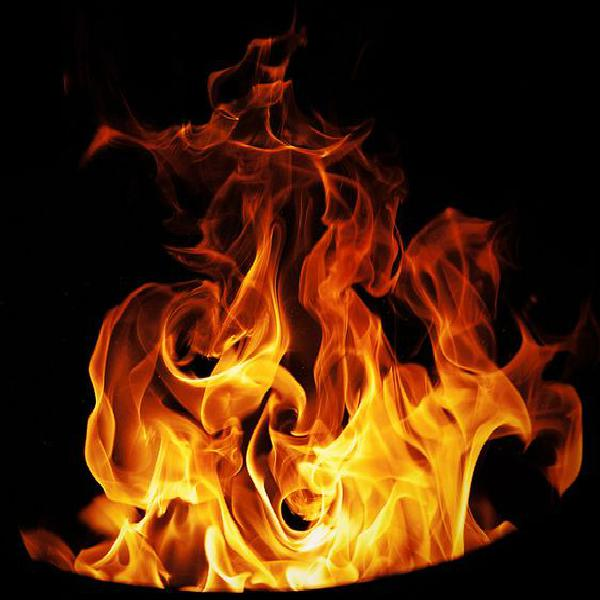

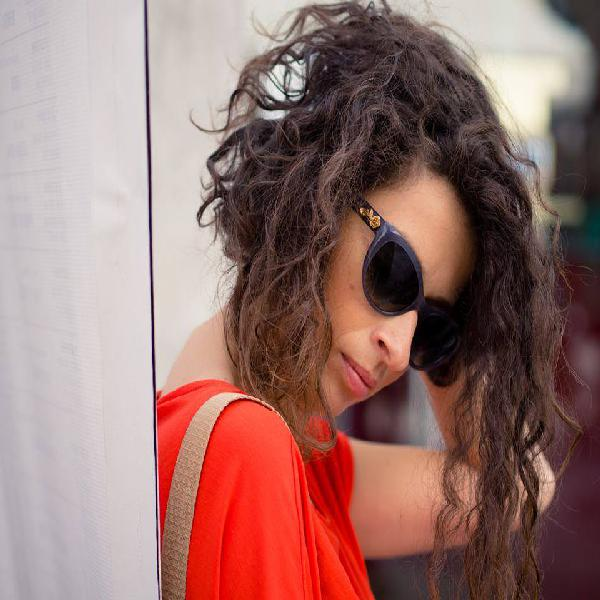

In [37]:
# Image which will define the style
style_image = load_image(size=(image_size), filename='images/fire.jpg')
show(style_image)

# Image to define the content
content_image = load_image(size=(image_size), filename='images/didi.jpg')
show(content_image)

## Step 2
Compute the style layers activations of the style input image, 
and the content layer activations of the content input image.

In [21]:
# Compute the style activations
style_layers_computed = sess.run(
         style_layers, 
         feed_dict={input_tensor: preprocess(style_image)})

# Compute the content activations
content_layers_computed = sess.run(
        content_layers, 
        feed_dict={input_tensor: np.expand_dims(content_image, 0)}) 

## Step 3 
Difference between style layers of result image and style layers of style image

In [23]:
def style_loss(current, computed):
    '''Define the style loss between a tensor and an np array.
    Args:
        current: tf.Tensor. The style activations of the current image.
        computed: np array. The style activations of the style input image.
    '''
    style_losses = []
    for layer1, layer2 in zip(current, computed):
        _, height, width, number = map(lambda i: i, layer2.shape)
        size = height * width * number

        # Compute layer1 Gram matrix
        feats1 = tf.reshape(layer1, (-1, number))
        layer1_gram = tf.matmul(tf.transpose(feats1), feats1) / size
        # Compute layer2 Gram matrix
        feats2 = tf.reshape(layer2, (-1, number))
        layer2_gram = tf.matmul(tf.transpose(feats2), feats2) / size
        
        dim1, dim2 = map(lambda i: i.value, layer1_gram.get_shape())
        loss =  tf.sqrt(tf.reduce_sum(tf.square((layer1_gram - layer2_gram) / (number * number))))
        style_losses.append(loss)
    return tf.add_n(style_losses)


## Step 4
Difference between content layers of result image and content layers of content image.

In [24]:
def content_loss(current, computed):
    # Currently only for a single layer
    _, height, width, number = computed.shape
    size = height * width * number
    return  tf.sqrt(tf.nn.l2_loss(current - computed) / size)

## Step 5
Total variation loss, designed to keep the generated image locally coherent.
https://en.wikipedia.org/wiki/Total_variation_denoising


In [25]:
def total_variation_loss(image):
    dims = image.get_shape()
    tv_x_size = dims[1].value * (dims[2].value - 1) * dims[3].value
    tv_y_size = (dims[1].value - 1) * dims[2].value * dims[3].value

    return (
            tf.reduce_sum(tf.abs(image[:,1:,:,:] - image[:,:-1,:,:])) +
            tf.reduce_sum(tf.abs(image[:,:,1:,:] - image[:,:,:-1,:])) 
    )

# Step 6.
Define the gradient to change a result image


In [26]:
def setup_gradient(input_tensor, result_tensor):
    '''Setup the gradient of the input tensor w.t.r 
    to the result tensor.
    Args: 
        input_tensor: The input features tensor.
        result_tensor: The tensor that we want to maximize.
    '''
    # First get the result tensor mean
    excitement_score = tf.reduce_mean(result_tensor)

    # Gradients give us how to change the input (input_tensor) 
    # to increase the excitement_score.
    # We get the first result only since the model is designed to
    # work on batches, and we only use single image.
    gradient = tf.gradients(excitement_score, input_tensor)[0]

    # Normalize the gradient by its L2 norm.
    # Disabled for now.
    # gradient /= (tf.sqrt(tf.reduce_mean(tf.square(gradient))) 
    #                            + 1e-5)

    return gradient, excitement_score

# How much content, style and total variance loss contribute to the 
# total loss.
content_weight = 1e3
style_weight = 1e6
tv_weight = 1e-3 

# Set up the style, content, total variation, as well as total loss 
# and use them to define the gradient.
with graph.as_default():
    with graph.name_scope("style_loss") as scope:
        style_loss_op = style_weight * style_loss(style_layers, style_layers_computed)
    with graph.name_scope("content_loss") as scope:    
        content_loss_op = content_weight * content_loss(content_layers, content_layers_computed)
    with graph.name_scope("tv_loss") as scope:
        tv_loss_op = tv_weight * total_variation_loss(input_tensor)
    with graph.name_scope("loss") as scope:    
        total_loss_op =  style_loss_op + content_loss_op + tv_loss_op
    with graph.name_scope("gradient") as scope:    
        gradient_op, score_op = setup_gradient(input_tensor, total_loss_op)

In [ ]:
# Uncomment this to display the whole TF Graph interactively
#display_graph(graph.as_graph_def())

## Step 7
Modify the result image by the gradient for a number of iterations.

### Define the gradient descent optimizer

In [28]:
with graph.as_default():
    # Start with a high learning rate initially.
    # Adam will gradually decrease this.
    learning_rate = 10
    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    # Compute the gradients for a list of variables.
    grads_and_vars = optimizer.compute_gradients(score_op, [input_tensor])
    # Op that ask the optimizer to apply the gradients.
    train_step = optimizer.apply_gradients(grads_and_vars)   

#### Initialize the internal variables Adam uses.
We could do tf.global_variables_initializer().eval() to 
initialize all variables but this messes up the keras model.

In [29]:
def get_uninitialized_variables(variables=None, session=None):
    """
    Get uninitialized variables in a session as a list.
        Args: 
            variables: list of tf.Variable. Get uninitiliazed vars 
                from these. If none, gets all uinitialized vars in session.
            session: tf.Session to find uninitialized vars in. If none
                uses default session.
        Returns:
            Uninitialized variables within `variables`.
            If `variables` not specified, return all uninitialized variables.
    """
    if not session:
        session = tf.get_default_session()
    if variables is None:
        variables = tf.global_variables()
    else:
        variables = list(variables)
    init_flag = session.run(
        tf.pack([tf.is_variable_initialized(v) for v in variables]))
    return [v for v, f in zip(variables, init_flag) if not f]

# Get uninitialized vars and their initializers
uninitialized_vars = get_uninitialized_variables()
initializers = [var.initializer for var in uninitialized_vars]

# Print uninitialized variables
print([initializer.name for initializer in initializers])

# Initialize the variables
_ = [initializer.run() for initializer in initializers]

[u'beta1_power/Assign', u'beta2_power/Assign', u'model/Variable/Adam/Assign', u'model/Variable/Adam_1/Assign', u'beta1_power_1/Assign', u'beta2_power_1/Assign', u'model/Variable/Adam_2/Assign', u'model/Variable/Adam_3/Assign']


### Define start image
The image we are going to start with is the content image, 
with random petrubations (needed, otherwise TV loss converges to nan).

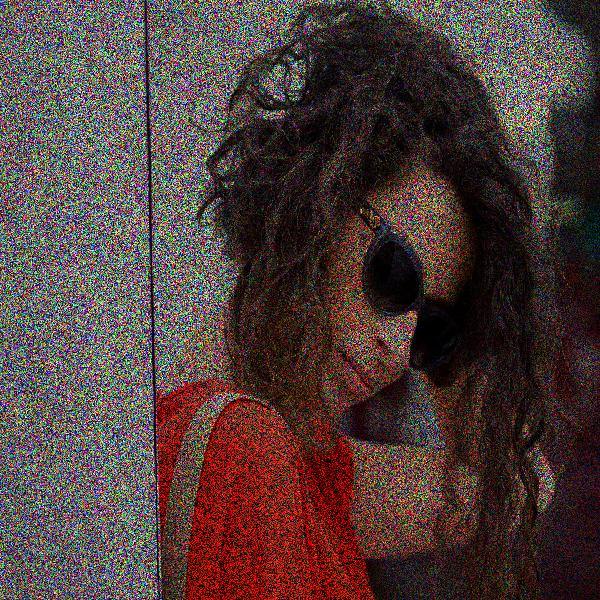

In [32]:
with graph.as_default():
    # Define random 0 to 1 image with size (batch_size, image_size, channels)
    initial_random = tf.random_normal(mean=0.5, stddev=.5, shape = (1,)+image_size+(3,))
    # Use the content image
    initial_content = np.expand_dims(content_image, axis=0)
    # Init the input tensor
    input_tensor.initializer.run()
    input_tensor.assign(tf.clip_by_value(initial_content * initial_random, 0, 255)).eval()
    # Show the input tensor
    show(np.squeeze(input_tensor.eval()))

## Run the optimizer
Run for a number of iterations. Display the losses every now and then

In [36]:
with graph.as_default():
    # Recommended at least 500 - 1000 iterations for a good quality image.
    # Good style should be visible even after 100 iters.
    iterations = 500
    # How many times to print the progress
    print_n_times = 5
    print_every_n = max(iterations // print_n_times, 1)

    # To compute total optimization time
    start_time = time.time()

    # Helper to print the losses.
    def print_progress(i, 
                       loss_computed, 
                       style_loss_computed, 
                       content_loss_computed,
                       tv_loss_computed):
            print('Iteration %d/%d Content L: %g Style L: %g TV L: %g Total L: %g' % (
                i, 
                iterations, 
                content_loss_computed,
                style_loss_computed,
                tv_loss_computed, 
                loss_computed
            ))


    # Keep only the image with the lowest loss
    # (in case we converge).
    best_loss = float('inf')
    best = None

    # Optimization loop
    for i in range(iterations):
        # Keep the input_tensor between 0 and 255
        # (gives slightly better output, slows optimization by factor of 2)
        # input_tensor.assign(tf.clip_by_value(input_tensor, 0, 255)).eval()
        
        # Run the training (train_step), and get the losses
        (_, result_image, loss_computed, 
         style_loss_computed, content_loss_computed,
         tv_loss_computed) = sess.run(
            [train_step, input_tensor, score_op, style_loss_op, content_loss_op,
            tv_loss_op])
        
        # Print progress
        if i % print_every_n == 0:
            print_progress(i, loss_computed, 
         style_loss_computed, content_loss_computed,
         tv_loss_computed)

        if loss_computed < best_loss:
            best_loss = loss_computed
            best = result_image 

    total_time = time.time() - start_time    
    print ('Training took {:.0f} seconds or {:.2f} s/iteration !'.format(
        total_time,
        total_time / iterations))

best = np.clip(best, 0, 255)

NameError: name 'iterations' is not defined

In [35]:
# Show the result.
show(np.squeeze(deprocess(best)))

## Gradient Descent by hand
We can do the gradient descent by hand, go gain a better understanding of it.

In [ ]:
with graph.as_default():
    # This might need to be lower.
    learning_rate = 10 
    
    # Recommended at least 500 - 1000 iterations for a good quality image.
    # Good style should be visible even after 100 iters.
    iterations = 500
    
    # How many times to print the progress
    print_n_times = 5
    print_every_n = max(iterations // print_n_times, 1)

    # To compute total optimization time
    start_time = time.time()

    # To display average losses
    content_losses = []
    style_losses = []
    tv_losses = []    
    # Run the optimization
    for i in range(iterations):
        (gradient_computed, score_computed, 
         style_loss_computed, content_loss_computed,
         tv_loss_computed) = sess.run(
            [gradient_op, score_op, style_loss_op, content_loss_op,
            tv_loss_op], 
            feed_dict={input_tensor: result_image})

        # Modify the current image by the gradient
        result_image -= gradient_computed * learning_rate
        
        # Clip for better quality image
        result_image = np.clip(result_image, 0, 256)

        # Store the losses to display 
        content_losses.append(content_loss_computed)
        style_losses.append(style_loss_computed)
        tv_losses.append(tv_loss_computed)
        
        # Print losses
        if (i % print_every_n == 0):
            print('Iteration: %d Loss: %g  Style L: %g  Content L: %g TV L: %g' %
                (i,
                score_computed, 
                np.asarray(style_losses).mean(), 
                np.asarray(content_losses).mean(),
                np.asarray(tv_losses).mean()))
            content_losses = []
            style_losses = []
            tv_losses = []
            
# Show what we got
show(np.squeeze(deprocess(result_image)))